### Importing the Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay,roc_curve, auc, RocCurveDisplay

from sklearn.ensemble import AdaBoostClassifier

pd.set_option('display.max_columns',None)
import warnings
warnings.filterwarnings('ignore')

### Model Training and Evaluation

In [3]:
# Loading the data

df = pd.read_csv('cleaned_data.csv')
df

,Unnamed: 0,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,Check-in Service,Online Boarding,Gate Location,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction
0,0,Male,48,First-time,Business,Business,821,2,5.0,3,3,4,3,3,3,5,2,5,5,5,3,5,5,0
1,1,Female,35,Returning,Business,Business,821,26,39.0,2,2,3,5,2,5,4,5,5,3,5,2,5,5,1
2,2,Male,41,Returning,Business,Business,853,0,0.0,4,4,4,5,4,3,5,3,5,5,3,4,3,3,1
3,3,Male,50,Returning,Business,Business,1905,0,0.0,2,2,3,4,2,5,5,5,4,4,5,2,5,5,1
4,4,Female,49,Returning,Business,Business,3470,0,1.0,3,3,3,5,3,3,4,4,5,4,3,3,3,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129482,129875,Male,28,Returning,Personal,Economy Plus,447,2,3.0,4,4,4,4,2,5,1,4,4,4,5,4,4,4,0
129483,129876,Male,41,Returning,Personal,Economy Plus,308,0,0.0,5,3,5,3,4,5,2,5,2,2,4,3,2,5,0
129484,129877,Male,42,Returning,Personal,Economy Plus,337,6,14.0,5,2,4,2,1,3,3,4,3,3,4,2,3,5,0
129485,129878,Male,50,Returning,Personal,Economy Plus,337,31,22.0,4,4,3,4,1,4,4,5,3,3,4,5,3,5,1


In [5]:
# Defining target and features column

X = df.drop(columns={'Satisfaction'})
y = df[['Satisfaction']]

In [7]:
# Train test split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=42)

print('The shape of X_train is {}'.format(X_train.shape))
print('The shape of X_test is {}'.format(X_test.shape))
print('The shape of y_train is {}'.format(y_train.shape))
print('The shape of y_test is {}'.format(y_test.shape))

The shape of X_train is (103589, 23)
The shape of X_test is (25898, 23)
The shape of y_train is (103589, 1)
The shape of y_test is (25898, 1)


In [9]:
# Scaling,encoding and fitting into pipeline

numerical_cols = [col for col in X.columns if X[col].dtypes!='O']
categorical_cols = [col for col in X.columns if X[col].dtypes=='O']

In [13]:
preprocessor = ColumnTransformer(transformers = [
    ('num',StandardScaler(),numerical_cols),
    ('cat',OneHotEncoder(),categorical_cols)
])

In [15]:
pipeline_ada= Pipeline(steps = [
    ('preprocessor',preprocessor),
    ('model',AdaBoostClassifier())
])

pipeline_ada.fit(X_train,y_train)

y_pred_train = pipeline_ada.predict(X_train)
y_pred_test = pipeline_ada.predict(X_test)
cv = cross_val_score(pipeline_ada, X_train, y_train, cv = 5, scoring = 'accuracy').mean()


print('Training Accuracy score: {:.2f}%'.format(accuracy_score(y_train, y_pred_train) * 100))
print('Testing Accuracy score : {:.2f}%'.format(accuracy_score(y_test, y_pred_test) * 100))
print('Cross validation score : {:.2f}%'.format(cv * 100))

if (abs(accuracy_score(y_train, y_pred_train) - cv) <= 0.05) and (abs(accuracy_score(y_train, y_pred_train) - accuracy_score(y_test, y_pred_test)) <= 0.05):
  print('Good Model')
else:
  print('Bad Model')

Training Accuracy score: 91.17%
Testing Accuracy score : 91.01%
Cross validation score : 91.32%
Good Model


In [19]:
### Hyperparameter Tuning

params = {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.3]
}

clf = RandomizedSearchCV(pipeline_ada,param_distributions=params,scoring='accuracy',cv=3,verbose=1)

clf.fit(X_train,y_train)

print(f'Best score : {clf.best_score_:.4f}')
print(f'Best params : {clf.best_params_}')

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best score : 0.9172
Best params : {'model__n_estimators': 200, 'model__learning_rate': 0.3}


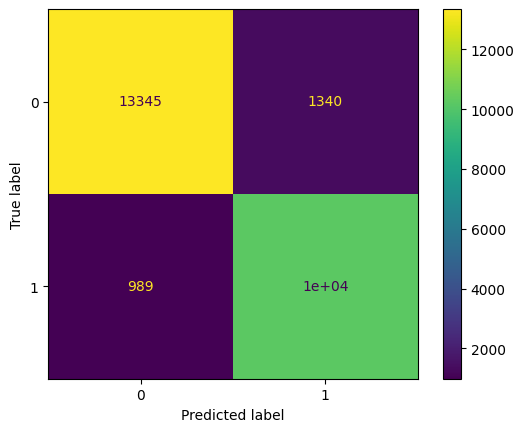

In [21]:
# Confusion Matrix

cm = confusion_matrix(y_test, y_pred_test)
ConfusionMatrixDisplay(cm).plot()

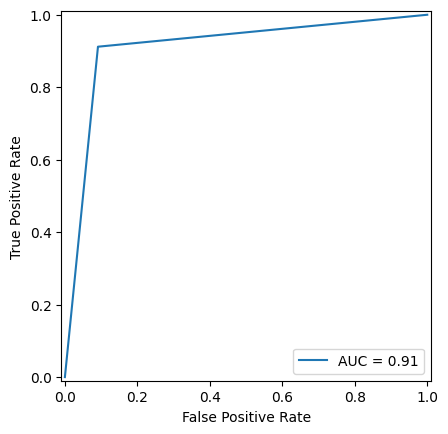

In [23]:
# ROC Curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

roc_auc = auc(fpr, tpr)

RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc).plot()